In [1]:
# %pip install qiskit
# %pip install qiskit_machine_learning
# %pip install datasets
# %pip install 'accelerate>=0.26.0'
# %pip install numpy
# %pip install pandas
# %pip install matplotlib
# %pip install seaborn
# %pip install torch
# %pip install transformers
# %pip install scikit-learn
# %pip install datasets
# %pip install kagglehub
# %pip install qiskit
# %pip install qiskit_machine_learning
# %pip install ipywidgets
# %pip install pylatexenc


In [2]:
from collections import Counter
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from qiskit import QuantumCircuit
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
import kagglehub
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)

from qiskit_machine_learning.utils import algorithm_globals

algorithm_globals.random_seed = 12345

##### Load and Prepare Dataset

#### Dataset from https://www.kaggle.com/datasets/lizhecheng/llm-science-dataset

In [3]:
file_path = kagglehub.dataset_download("lizhecheng/llm-science-dataset")
data = pd.read_csv(f"{file_path}/High Quality Dataset.csv")
data.columns = data.columns.str.strip()

##### Convert letter answers (A-E) to label index

In [4]:
data['answer'] = data['answer'].str.strip().str.upper()
label_to_id = {label: idx for idx, label in enumerate(sorted(data['answer'].unique()))}
id_to_label = {v: k for k, v in label_to_id.items()}
data['label'] = data['answer'].map(label_to_id)

##### Format full prompt from prompt + A–E choices

In [5]:
def format_prompt_with_correct_answer(row):
    option_letter = row['answer']
    if option_letter in ['A', 'B', 'C', 'D', 'E']:
        correct_text = row.get(option_letter, '[Missing]')
        return f"{row['prompt']}\nCorrect: {option_letter}: {correct_text}"
    else:
        return f"{row['prompt']}\nCorrect: {option_letter}: [Invalid answer]"

data['full_prompt'] = data.apply(format_prompt_with_correct_answer, axis=1)

##### Filter out rare labels (only 1 sample)

In [6]:
label_counts = Counter(data['label'])
valid_labels = [label for label, count in label_counts.items() if count > 1]
data = data[data['label'].isin(valid_labels)]

##### Train-test split with stratification

In [7]:
train_df, test_df = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)
train_df.to_csv("train_dataset.csv", index=False)
test_df.to_csv("test_dataset.csv", index=False)

##### Reload for processing

In [8]:
X_train = train_df['full_prompt'].values
y_train = train_df['label'].values
X_test = test_df['full_prompt'].values
y_test = test_df['label'].values

##### TF-IDF + PCA

In [ ]:
tfidf = TfidfVectorizer(max_features=200)
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_tfidf)
X_test_scaled = scaler.transform(X_test_tfidf)

n_dimensions = 3
pca = PCA(n_components=n_dimensions)
X_train_reduced = pca.fit_transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)

##### Quantum Feature Map Layer

In [10]:
def create_qnn():
    num_qubits = 3
    feature_map = ZZFeatureMap(feature_dimension=num_qubits)
    ansatz = RealAmplitudes(num_qubits=num_qubits, reps=2)

    qc = QuantumCircuit(num_qubits)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True
    )
    return qnn

##### Hybrid model

In [11]:
class QuantumTransformer(nn.Module):
    def __init__(self, quantum_layer, input_dim, embed_dim, num_heads, ff_dim, num_classes, max_seq_len=100):
        super().__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=0.2),
            num_layers=2
        )
        self.quantum_layer = quantum_layer
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(embed_dim + 1, num_classes)

    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids.float())
        x = x.unsqueeze(1)
        x = x + self.pos_embedding
        x = x.permute(1, 0, 2)
        x = self.transformer(x)
        x = x.permute(1, 0, 2).mean(dim=1)
        quantum_input = torch.rand(x.size(0), 3).to(x.device)
        quantum_out = self.quantum_layer(quantum_input)
        x = torch.cat((x, quantum_out), dim=1)
        x = self.dropout(x)
        return self.classifier(x)

##### Tokenization

In [12]:
tokenizer = TfidfVectorizer(max_features=100, token_pattern=r"(?u)\b\w+\b")
tfidf_train = tokenizer.fit_transform(X_train)
tfidf_test = tokenizer.transform(X_test)

X_train_tensor = torch.tensor(tfidf_train.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(tfidf_test.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

##### Set device

In [13]:
device = torch.device("mps" if torch.has_mps else "cpu")

##### Fit model

In [14]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
full_weights = np.zeros(len(label_to_id), dtype=np.float32)
for i, class_idx in enumerate(np.unique(y_train)):
    full_weights[class_idx] = class_weights[i]
weights_tensor = torch.tensor(full_weights, dtype=torch.float32).to(device)

quantum_layer = TorchConnector(create_qnn())
model = QuantumTransformer(quantum_layer, input_dim=100, embed_dim=128, num_heads=4, ff_dim=256, num_classes=len(label_to_id)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.CrossEntropyLoss(weight=weights_tensor)

train_history = {'loss': [], 'accuracy': []}
dataset = TensorDataset(X_train_tensor, y_train_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

print("🚀 Training hybrid Quantum Transformer model...")
model.train()
for epoch in range(5):
    total_loss = 0
    correct = 0
    total = 0
    loop = tqdm(loader, desc=f"Epoch {epoch+1}", leave=False)
    for X_batch, y_batch in loop:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
        loop.set_postfix(loss=loss.item())

    epoch_loss = total_loss / len(loader)
    epoch_acc = correct / total
    train_history['loss'].append(epoch_loss)
    train_history['accuracy'].append(epoch_acc)
    print(f"Epoch {epoch+1} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}")

🚀 Training hybrid Quantum Transformer model...


Epoch 1 | Loss: 1.3332 | Accuracy: 0.4127


Epoch 2 | Loss: 0.1446 | Accuracy: 0.9564


Epoch 3 | Loss: 0.0681 | Accuracy: 0.9826


Epoch 4 | Loss: 0.0669 | Accuracy: 0.9815


Epoch 5 | Loss: 0.0653 | Accuracy: 0.9815


##### Plot Evaluation

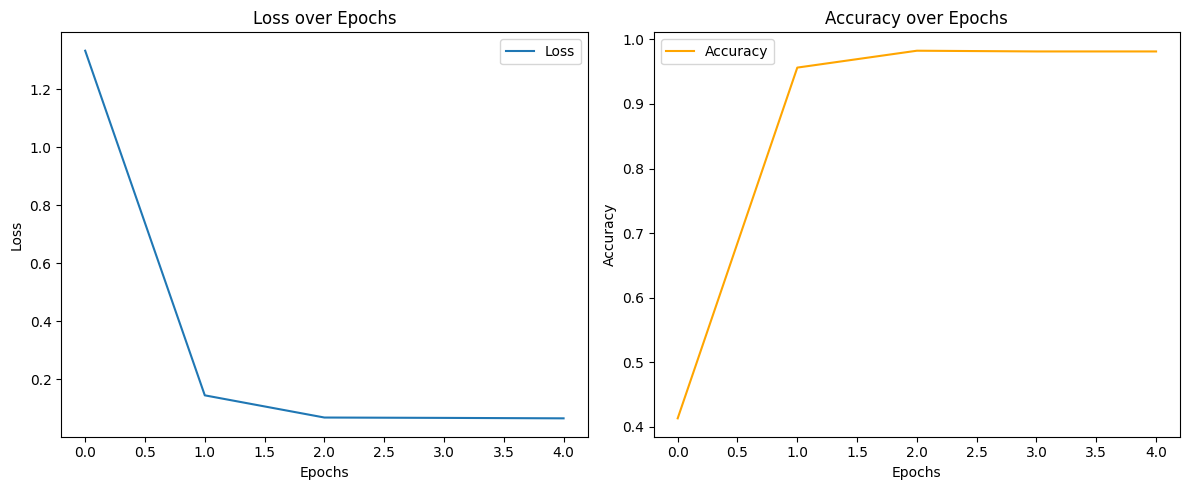

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_history['loss'], label='Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_history['accuracy'], label='Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

##### Evaluation Preparation

In [16]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    outputs = model(X_test_tensor)
    y_pred = torch.argmax(outputs, dim=1).cpu().numpy()
    y_true = y_test_tensor.cpu().numpy()

##### Evaluation Metrics

In [17]:
print(f"🧪 Test Accuracy: {metrics.accuracy_score(y_true, y_pred):.4f}")
print("📋 Classification Report:")
target_names = [id_to_label[i] for i in sorted(set(y_true) | set(y_pred))]
print(metrics.classification_report(y_true, y_pred, target_names=target_names))

🧪 Test Accuracy: 0.9875
📋 Classification Report:
              precision    recall  f1-score   support

           A       0.99      0.98      0.99       426
           B       0.99      0.98      0.98       363
           C       0.99      0.99      0.99       350
           D       0.98      0.99      0.98       322
           E       1.00      0.99      0.99       306

    accuracy                           0.99      1767
   macro avg       0.99      0.99      0.99      1767
weighted avg       0.99      0.99      0.99      1767



##### Confusion Matrix

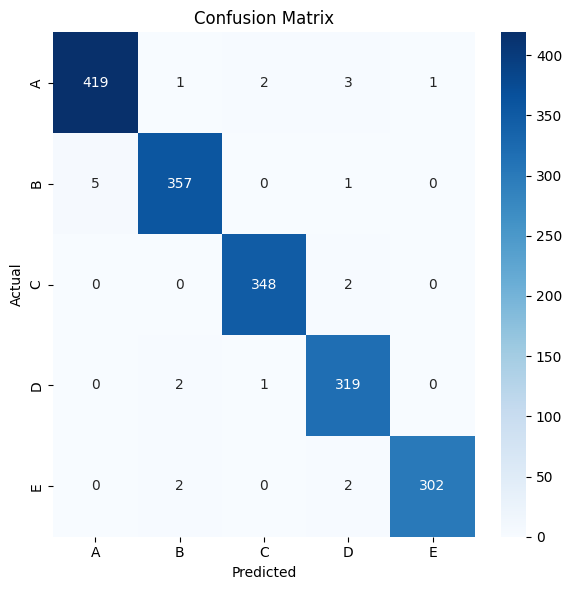

In [18]:
conf_matrix = metrics.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=[id_to_label[i] for i in sorted(label_to_id.values())],
            yticklabels=[id_to_label[i] for i in sorted(label_to_id.values())])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [19]:
import utils.tutorial_magics

%qiskit_version_table
%qiskit_copyright